In [12]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [13]:
import logging
# Suppress Prophet/cmdstanpy logs
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
logging.getLogger("prophet").setLevel(logging.CRITICAL)

In [14]:
# ------------------------------
# STEP 1: Load and prepare data
# ------------------------------
df = pd.read_csv("Quarterly_Retail_Sales_Tax_Data_by_County_and_City.csv")
df = df[['Quarter Ending', 'County', 'City', 'Computed Tax']].dropna()
df['ds'] = pd.to_datetime(df['Quarter Ending'])
df['y'] = df['Computed Tax']


In [15]:
# ------------------------------
# STEP 2: Get all unique combos
# ------------------------------
combos = df[['County', 'City']].drop_duplicates().values.tolist()
results = []


In [16]:
# ------------------------------
# STEP 3: Loop through each combo
# ------------------------------
for county, city in combos:
    subset = df[(df['County'] == county) & (df['City'] == city)][['ds', 'y']].sort_values('ds')

    if len(subset) < 12:
        continue  # Skip short histories

    try:
        # Train-test split (80-20)
        train_size = int(len(subset) * 0.8)
        train = subset.iloc[:train_size]
        test = subset.iloc[train_size:]
 
        # Fit Prophet
        model = Prophet(yearly_seasonality=True)
        model.fit(train)

        # Forecast into test period
        future = model.make_future_dataframe(periods=len(test), freq='Q')
        forecast = model.predict(future)

        # Evaluate accuracy
        y_true = test['y'].values
        y_pred = forecast['yhat'][-len(test):].values

        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        results.append({
    'County': county,
    'City': city,
    'Data Points': len(subset),
    'MAPE': round(mape, 2),
    'MAE': round(mae, 2),
    'RMSE': round(rmse, 2),
    'R2 Score': round(r2, 2)
})


    except Exception:
        continue  # Skip any combo that errors


In [17]:

# ------------------------------
# STEP 4: Export Results
# ------------------------------
df_results = pd.DataFrame(results).sort_values(by='MAPE')
df_results.to_csv("prophet_city_mape.csv", index=False)
print("✅ Prophet MAPE scores saved to 'prophet_city_mape.csv'")

✅ Prophet MAPE scores saved to 'prophet_city_mape.csv'


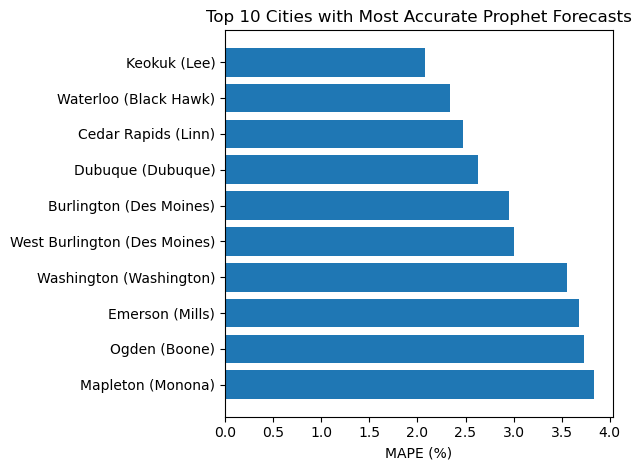

In [20]:
# Bar chart for top 10 cities by MAPE
import matplotlib.pyplot as plt
top_10 = df.sort_values(by='MAPE').head(10)
plt.barh(top_10['City'] + " (" + top_10['County'] + ")", top_10['MAPE'])
plt.xlabel("MAPE (%)")
plt.title("Top 10 Cities with Most Accurate Prophet Forecasts")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
